In [1]:
#imports
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from xgboost import XGBClassifier


**Notebook diagnostic:** Run the next code cell to show which Python executable this notebook kernel is using and whether numpy is importable. If numpy is missing, run the third cell to install it into this kernel.

In [ ]:
#Dataset Generation Function
def generate_dataset(n, seed=42):
    np.random.seed(seed)

    RBC = np.random.normal(6.5, 1.0, n).clip(4.0, 9.0)
    WBC = np.random.normal(10, 3.0, n).clip(4.0, 18.0)
    HB  = np.random.normal(13, 2.5, n).clip(7.0, 20.0)
    Platelets = np.random.normal(300, 80, n).clip(100, 700)
    Creatinine = np.random.normal(1.0, 0.3, n).clip(0.3, 2.5)
    Glucose    = np.random.normal(100, 25, n).clip(50, 200)
    Dose = np.random.uniform(0.3, 1.3, n)

    # Probabilistic risk score
    risk_score = (
        0.2 * (HB / 20) +
        0.15 * (RBC / 9) -
        0.2 * (Creatinine / 2.5) -
        0.1 * (Dose / 1.3)
    )

    # Biological noise - increased for better distribution
    risk_score += np.random.normal(0, 0.02, n)
    

    # Sigmoid probability with better threshold
    prob_safe = 1 / (1 + np.exp(-risk_score))

    Outcome = (prob_safe > 0.5).astype(int)

    return pd.DataFrame({
        "RBC": RBC,
        "WBC": WBC,
        "HB": HB,
        "Platelets": Platelets,
        "Creatinine": Creatinine,
        "Glucose": Glucose,
        "Dose": Dose,
        "Outcome": Outcome
    })


In [12]:
# Generate datasets and save to CSV
df_1000 = generate_dataset(1000, seed=1042)
df_1250 = generate_dataset(1250, seed=1292)

df_1000.to_csv("smart_vet_dose_1000.csv", index=False)
df_1250.to_csv("smart_vet_dose_1250.csv", index=False)

df_1000.shape, df_1250.shape


((1000, 8), (1250, 8))

In [ ]:
#Model Evaluation Function
def evaluate_models(df):
    X = df.drop("Outcome", axis=1)
    y = df["Outcome"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=42
    )

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    results = {}

    # Logistic Regression
    lr = LogisticRegression(max_iter=1000)
    lr.fit(X_train_scaled, y_train)
    lr_pred = lr.predict(X_test_scaled)

    results["Logistic Regression"] = {
        "Accuracy": accuracy_score(y_test, lr_pred),
        "Precision": precision_score(y_test, lr_pred, zero_division=0),
        "Recall": recall_score(y_test, lr_pred, zero_division=0),
        "F1": f1_score(y_test, lr_pred, zero_division=0)
    }

    # Random Forest
    rf = RandomForestClassifier(n_estimators=200, random_state=42)
    rf.fit(X_train, y_train)
    rf_pred = rf.predict(X_test)

    results["Random Forest"] = {
        "Accuracy": accuracy_score(y_test, rf_pred),
        "Precision": precision_score(y_test, rf_pred, zero_division=0),
        "Recall": recall_score(y_test, rf_pred, zero_division=0),
        "F1": f1_score(y_test, rf_pred, zero_division=0)
    }

    # XGBoost
    xgb = XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=4,
        eval_metric="logloss"
    )
    xgb.fit(X_train, y_train)
    xgb_pred = xgb.predict(X_test)

    results["XGBoost"] = {
        "Accuracy": accuracy_score(y_test, xgb_pred),
        "Precision": precision_score(y_test, xgb_pred, zero_division=0),
        "Recall": recall_score(y_test, xgb_pred, zero_division=0),
        "F1": f1_score(y_test, xgb_pred, zero_division=0)
    }

    return results


In [13]:
#Final Evaluation Loop (Run this cell to evaluate models on different dataset sizes)
dataset_sizes = [400, 700, 1000, 1250]
final_results = []

for size in dataset_sizes:
    df = generate_dataset(size, seed=42 + size)
    model_results = evaluate_models(df)

    for model, metrics in model_results.items():
        final_results.append({
            "Dataset Size": size,
            "Model": model,
            **metrics
        })

results_df = pd.DataFrame(final_results)
results_df


,Dataset Size,Model,Accuracy,Precision,Recall,F1
0,400,Logistic Regression,0.730000,0.744898,0.973333,0.843931
1,400,Random Forest,0.750000,0.765957,0.960000,0.852071
2,400,XGBoost,0.750000,0.790698,0.906667,0.844720
3,700,Logistic Regression,0.725714,0.725714,1.000000,0.841060
4,700,Random Forest,0.725714,0.733728,0.976378,0.837838
5,700,XGBoost,0.725714,0.748428,0.937008,0.832168
6,1000,Logistic Regression,0.712000,0.728033,0.961326,0.828571
7,1000,Random Forest,0.688000,0.724891,0.917127,0.809756
8,1000,XGBoost,0.684000,0.747573,0.850829,0.795866
9,1250,Logistic Regression,0.757188,0.754045,1.000000,0.859779


In [14]:
#Save Results to CSV and Pivot Table
results_df.to_csv("model_results.csv", index=False)

results_df_pivot = results_df.pivot_table(
    index=["Dataset Size", "Model"],
    values=["Accuracy", "Precision", "Recall", "F1"]
).reset_index()

results_df_pivot


,Dataset Size,Model,Accuracy,F1,Precision,Recall
0,400,Logistic Regression,0.730000,0.843931,0.744898,0.973333
1,400,Random Forest,0.750000,0.852071,0.765957,0.960000
2,400,XGBoost,0.750000,0.844720,0.790698,0.906667
3,700,Logistic Regression,0.725714,0.841060,0.725714,1.000000
4,700,Random Forest,0.725714,0.837838,0.733728,0.976378
5,700,XGBoost,0.725714,0.832168,0.748428,0.937008
6,1000,Logistic Regression,0.712000,0.828571,0.728033,0.961326
7,1000,Random Forest,0.688000,0.809756,0.724891,0.917127
8,1000,XGBoost,0.684000,0.795866,0.747573,0.850829
9,1250,Logistic Regression,0.757188,0.859779,0.754045,1.000000


In [15]:
#Model Accuracy Summary
results_df.groupby("Model")["Accuracy"].agg(["mean", "min", "max"]).round(3)


,mean,min,max
Model,,,
Logistic Regression,0.731,0.712,0.757
Random Forest,0.728,0.688,0.750
XGBoost,0.716,0.684,0.750


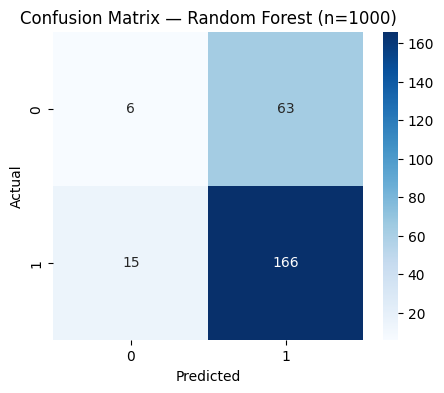

In [16]:
#Confusion Matrix Visualization for Random Forest on 1000 Samples
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

df = df_1000
X = df.drop("Outcome", axis=1)
y = df["Outcome"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix — Random Forest (n=1000)")
plt.show()
